**Set up notebook:**

In [1]:
#Configure Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Path to dataset folder
data_folder = '/content/drive/My Drive/MA/'

Mounted at /content/drive


In [ ]:
#Upload file locally
from google.colab import files

uploaded = files.upload()

In [2]:
#Import required libraries for this notebook
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.models import model_from_json, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns
from sklearn.linear_model import LinearRegression

**Load dataset:**

In [3]:
#Read WTG data
signals = 'wind-farm-1-signals-training.csv'
signals_test = 'wind-farm-1-signals-testing.csv'
all_data = pd.concat([pd.read_csv(data_folder + signals, delimiter=';'), pd.read_csv(data_folder + signals_test, delimiter=';')], ignore_index=True)
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'])
all_data.set_index('Timestamp', inplace=True)

#Filter T_11 data out
#wtg_data = all_data[all_data.Turbine_ID == 'T11'].reset_index().drop(columns=['index'])

#wtg_data = wtg_data[wtg_data['Grd_Prod_Pwr_Avg'] > 0]
print(all_data.dtypes)
all_data.head()

Turbine_ID                object
Gen_RPM_Max              float64
Gen_RPM_Min              float64
Gen_RPM_Avg              float64
Gen_RPM_Std              float64
                          ...   
Grd_Prod_PsbleCap_Max    float64
Grd_Prod_PsbleCap_Min    float64
Grd_Prod_PsbleCap_Std    float64
Gen_Bear2_Temp_Avg         int64
Nac_Direction_Avg        float64
Length: 82, dtype: object


,Turbine_ID,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,...,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,T11,1339.4,1233.3,1270.9,18.8,42.0,59,61,60,30,...,-973.4,-752.6,-1000.0,56.5,973.4,1000.0,752.6,56.5,38,206.9
2016-01-01 00:00:00+00:00,T06,1270.0,1232.8,1248.5,6.8,42.0,51,52,53,30,...,-307.1,0.0,-880.6,180.0,307.1,880.6,0.0,180.0,35,204.6
2016-01-01 00:00:00+00:00,T01,1277.4,1226.1,1249.0,9.0,41.0,58,59,58,30,...,-144.4,0.0,-584.5,157.1,144.4,584.5,0.0,157.1,37,218.5
2016-01-01 00:00:00+00:00,T09,1376.7,1234.3,1272.0,24.7,40.0,58,57,58,44,...,-861.6,-224.5,-1000.0,185.5,861.6,1000.0,224.5,185.5,33,214.0
2016-01-01 00:00:00+00:00,T07,1317.5,1229.5,1254.9,13.8,41.0,62,62,61,32,...,-536.5,0.0,-1000.0,338.9,536.5,1000.0,0.0,338.9,39,197.3


In [4]:
all_data.tail()

,Turbine_ID,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,...,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-12-31 23:50:00+00:00,T11,1320.5,1216.8,1262.0,20.6,42.0,56,58,57,28,...,-1000.0,-1000.0,-1000.0,0.0,1000.0,1000.0,1000.0,0.0,37,331.5
2017-12-31 23:50:00+00:00,T07,1329.9,1193.0,1257.6,18.9,38.0,61,61,61,30,...,-966.0,-256.3,-1000.0,109.8,966.0,1000.0,256.3,109.8,32,334.8
2017-12-31 23:50:00+00:00,T01,1273.1,1239.8,1250.7,4.7,39.0,59,59,59,26,...,-983.9,-727.0,-1000.0,50.2,983.9,1000.0,727.0,50.2,38,347.8
2017-12-31 23:50:00+00:00,T09,1258.3,1239.7,1249.5,3.1,39.0,60,58,60,45,...,-955.8,-372.9,-1000.0,119.2,955.8,1000.0,372.9,119.2,32,339.7
2017-12-31 23:50:00+00:00,T06,1270.8,1229.6,1249.4,6.6,42.0,56,58,58,28,...,-793.6,-99.8,-1000.0,259.5,793.6,1000.0,99.8,259.5,40,325.1


In [ ]:
#Read log data
logs = 'wind-farm-1-logs-training.csv'
logs_test = 'wind-farm-1-logs-testing.csv'
log_data = pd.concat([pd.read_csv(data_folder + logs, delimiter=';'), pd.read_csv(data_folder + logs_test, delimiter=';')], ignore_index=True)
log_data['TimeDetected'] = pd.to_datetime(log_data['TimeDetected'])
log_data.set_index('TimeDetected', inplace=True)
log_data = log_data[log_data['UnitTitle'] == 'T11']
log_data.head()

,TimeReset,UnitTitle,Remark,UnitTitleDestination
TimeDetected,,,,
2016-01-01 00:02:18+00:00,NaN,T11,External power ref.:2000kW,NaN
2016-01-01 00:32:18+00:00,NaN,T11,External power ref.:2000kW,NaN
2016-01-01 01:02:18+00:00,NaN,T11,External power ref.:2000kW,NaN
2016-01-01 01:32:17+00:00,NaN,T11,External power ref.:2000kW,NaN
2016-01-01 02:02:17+00:00,NaN,T11,External power ref.:2000kW,NaN


In [ ]:
log_data.tail()

,TimeReset,UnitTitle,Remark,UnitTitleDestination
TimeDetected,,,,
2017-12-31 21:30:17+00:00,NaN,T11,External power ref.:2000kW,NaN
2017-12-31 22:00:17+00:00,NaN,T11,External power ref.:2000kW,NaN
2017-12-31 22:30:16+00:00,NaN,T11,External power ref.:2000kW,NaN
2017-12-31 23:00:16+00:00,NaN,T11,External power ref.:2000kW,NaN
2017-12-31 23:30:16+00:00,NaN,T11,External power ref.:2000kW,NaN


In [ ]:
#Logs containing "brake"
log_data[log_data.Remark.str.contains('Hyd')]

,TimeReset,UnitTitle,Remark,UnitTitleDestination
TimeDetected,,,,
2016-02-12 08:08:21+00:00,NaN,T11,"Feedback = 0,:Hydraulicmotor",NaN
2016-05-12 15:24:26+00:00,NaN,T11,"Feedback = 0,:Hydraulicmotor",NaN
2016-06-17 23:57:41+00:00,NaN,T11,"Feedback = 0,:Hydraulicmotor",NaN
2016-08-07 15:45:59+00:00,NaN,T11,"Feedback = 0,:Hydraulicmotor",NaN
2016-08-31 08:28:46+00:00,NaN,T11,"Feedback = 0,:Hydraulicmotor",NaN
2016-09-22 13:36:53+00:00,2016-09-22 13:37:24,T11,No Pitch Hydraulic Power,NaN
2017-09-11 10:49:03+00:00,NaN,T11,"Hydr max time: 60sec, 0bar",NaN


In [ ]:
#====================================================================================================================================================

**Set up functions to implement ML pipeline**

In [5]:
def get_train_test_data(dataset: pd.DataFrame, train_date_start, train_date_end, test_date_start, test_date_end):
  
  train_data = dataset[train_date_start : train_date_end]

  test_data = dataset[test_date_start : test_date_end]

  return train_data, test_data

In [6]:
def get_X_Y(dataset: pd.DataFrame, y_column):
  #Drop rows with NaN values
  XY = dataset.dropna()
  #Split data to X and Y
  X = XY.drop(y_column, axis=1)
  Y = XY[[y_column]]

  return X,Y

In [7]:
def normalize_X_Y_train(X: pd.DataFrame, Y: pd.DataFrame):
  scaler_input = MinMaxScaler(feature_range=(0, 1))
  scaler_input = scaler_input.fit(X)

  scaler_target = MinMaxScaler(feature_range=(0, 1))
  scaler_target = scaler_target.fit(Y)

  X_normalized = pd.DataFrame(scaler_input.transform(X), columns=X.columns, index=X.index)
  Y_normalized = pd.DataFrame(scaler_target.transform(Y), columns=Y.columns, index= Y.index)

  return X_normalized, Y_normalized, scaler_input, scaler_target

In [8]:
def normalize_X_Y_test(X: pd.DataFrame, Y: pd.DataFrame, scaler_input, scaler_target):
  X_normalized = pd.DataFrame(scaler_input.transform(X), columns=X.columns, index=X.index)
  Y_normalized = pd.DataFrame(scaler_target.transform(Y), columns=Y.columns, index= Y.index)

  return X_normalized, Y_normalized

In [9]:
from keras import callbacks
def get_trained_MLP(x: pd.DataFrame, y: pd.DataFrame, model=None, dense_1_shape=16, dense_2_shape=8, dense_3_shape=4, epochs=100, batch_size=100, verbose=2):
  #Train model further
  if model:
    model.fit(x, y, epochs=epochs, batch_size = batch_size, verbose = verbose, shuffle=False)
    return model

  #Otherwise, create new model
  model = Sequential([
            Input(x.shape[1]),
            Dense(dense_1_shape),
            Dropout(0.3),
            Dense(dense_2_shape),
            Dropout(0.3),
            Dense(y.shape[1])
        ])
  model.summary()

  #Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')

  #Train model
  callback = EarlyStopping(monitor='loss', patience=10, mode='min', restore_best_weights=True)
  model.fit(x, y, epochs=epochs, batch_size = batch_size, verbose = verbose, shuffle=False, callbacks=[callback])

  return model

In [10]:
def get_trained_reg(x: pd.DataFrame, y: pd.DataFrame):
  return LinearRegression().fit(x, y)

In [11]:
def plot_predicted_vs_true(predictions: pd.DataFrame, ground_truth: pd.DataFrame, y_column, hue=None):

  #predictions = predictions.rename(columns={y_column : y_column + '_pred'})
  #ground_truth = ground_truth.rename(columns={y_column : y_column + '_true'})
  fig, ax = plt.subplots(figsize=(25,7))
  if hue:
    ax.plot(ground_truth[ground_truth[hue] == False].index, ground_truth[ground_truth[hue] == False][y_column], label='Ground truth (no {})'.format(hue), color='blue', marker='o')
    ax.plot(ground_truth[ground_truth[hue] == True].index, ground_truth[ground_truth[hue] == True][y_column], label='Ground truth ({})'.format(hue), color='orange', marker='x')
  else:
    ax.plot(ground_truth.index, ground_truth[y_column], label='Ground truth', color='blue', marker='o')

  ax.plot(predictions.index, predictions[y_column], label='Simulation', color='green')

  ax.grid(True)

  ax.legend()
  ax.set_xlabel('Timestamp')
  ax.set_ylabel('Hydraulic Oil Temp [0C]')

  '''
  df = predictions.join(ground_truth)

  fig = plt.figure(figsize=(25,7))
  sns.lineplot(data=df)
  '''
  '''
  fig, ax = plt.subplots(figsize=(25,7))
  ax.plot(ground_truth.index, ground_truth[y_column], color = 'green')
  ax.plot(predictions.index, predictions[y_column], color = 'blue')

  ax.grid(True)

  ax.legend(['Ground Truth', 'Simulation'])
  ax.set_xlabel('Timestamp')
  ax.set_ylabel('Hydraulic Oil Temp [0C]')
  '''

In [12]:
def plot_error(predictions: pd.DataFrame, ground_truth: pd.DataFrame, y_column):
  fig, ax = plt.subplots(figsize=(25,7))
  errors = ((ground_truth[y_column] - predictions[y_column] ) / ground_truth[y_column]) * 100
  ax.plot(errors, color = 'red')

  ax.grid(True)

  ax.set_xlabel('Timestamp')
  ax.set_ylabel('Error [%]')

  return pd.DataFrame(errors)

In [13]:
def implement_pipeline_reg(dataset: pd.DataFrame, train_date_start, train_date_end, test_date_start, test_date_end, y_column, turbine_id=None, features=None):
  if turbine_id:
    dataset = dataset[dataset.Turbine_ID == turbine_id]
  if features:
    dataset = dataset[features]

  #Split dataset to training and test
  train_data, test_data = get_train_test_data(dataset, train_date_start, train_date_end, test_date_start, test_date_end)
  
  #X-Y split
  X_train, Y_train = get_X_Y(train_data, y_column)
  X_test, Y_test = get_X_Y(test_data, y_column)
  '''
  #Normalize data
  x_train, y_train, scaler_input, scaler_target = normalize_X_Y_train(X_train, Y_train)
  '''
  #Train model
  print('Training model...')
  model = get_trained_reg(X_train, Y_train)

  #Evaluate model
  #x_test, y_test = normalize_X_Y_test(X_test, Y_test, scaler_input, scaler_target)
  print('Evaluating model...')
  print('Score for training data: ', model.score(X_train, Y_train))
  print('Score for test data: ', model.score(X_test, Y_test))

  #Calculate errors
  predictions_train = pd.DataFrame(model.predict(X_train), columns=Y_train.columns, index=Y_train.index)
  errors_train = pd.DataFrame(Y_train[y_column] - predictions_train[y_column])

  predictions_test = pd.DataFrame(model.predict(X_test), columns=Y_test.columns, index=Y_test.index)
  errors_test = pd.DataFrame(Y_test[y_column] - predictions_test[y_column])

  return dataset, X_train, Y_train, predictions_train, errors_train, X_test, Y_test, predictions_test, errors_test, model


In [14]:
def implement_pipeline_mlp(dataset: pd.DataFrame, train_date_start, train_date_end, test_date_start, test_date_end, y_column, turbine_id=None, features=None,
                           model=None, dense_1_shape=32, dense_2_shape=16, epochs=10, batch_size=100, verbose=2, normalize=False):
  if turbine_id:
    dataset = dataset[dataset.Turbine_ID == turbine_id]
  if features:
    dataset = dataset[features]

  #Split dataset to training and test
  train_data, test_data = get_train_test_data(dataset, train_date_start, train_date_end, test_date_start, test_date_end)
  
  #X-Y split
  X_train, Y_train = get_X_Y(train_data, y_column)
  X_test, Y_test = get_X_Y(test_data, y_column)
  
  if normalize:
    #Normalize data
    x_train, y_train, scaler_input, scaler_target = normalize_X_Y_train(X_train, Y_train)
    
    #Train model
    print('Training model...')
    model = get_trained_MLP(x_train, y_train, epochs=epochs)

    #Evaluate model
    x_test, y_test = normalize_X_Y_test(X_test, Y_test, scaler_input, scaler_target)
    print('Evaluating model...')
    print('Score for training data: ', model.evaluate(x_train, y_train))
    print('Score for test data: ', model.evaluate(x_test, y_test))

    #Calculate errors
    predictions_train = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_train)), columns=Y_train.columns, index=x_train.index)
    errors_train = pd.DataFrame(Y_train[y_column] - predictions_train[y_column])

    predictions_test = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_test)), columns=Y_test.columns, index=x_test.index)
    errors_test = pd.DataFrame(Y_test[y_column] - predictions_test[y_column])


  else:
    #Train model
    print('Training model...')
    model = get_trained_MLP(X_train, Y_train, epochs=epochs)

    #Evaluate model
    x_test, y_test = normalize_X_Y_test(X_test, Y_test, scaler_input, scaler_target)
    print('Evaluating model...')
    print('Score for training data: ', model.evaluate(X_train, Y_train))
    print('Score for test data: ', model.evaluate(X_test, Y_test))

    #Calculate errors
    predictions_train = pd.DataFrame(model.predict(X_train), columns=Y_train.columns, index=X_train.index)
    #predictions_train = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_train)), columns=Y_train.columns, index=x_train.index)
    errors_train = pd.DataFrame(Y_train[y_column] - predictions_train[y_column])

    predictions_test = pd.DataFrame(model.predict(X_test), columns=Y_test.columns, index=X_test.index)
    #predictions_test = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_test)), columns=Y_test.columns, index=x_test.index)
    errors_test = pd.DataFrame(Y_test[y_column] - predictions_test[y_column])

  return dataset, X_train, Y_train, predictions_train, errors_train, X_test, Y_test, predictions_test, errors_test, model, scaler_input, scaler_target


In [ ]:
#====================================================================================================================================================

**Baseline using Linear Regression**

In [15]:
y_column = 'Hyd_Oil_Temp_Avg'

**Batch 1:** Train between Jan and September, Test between October 2016 and December 2017

In [16]:
features = ['Nac_Temp_Avg', 'Gen_SlipRing_Temp_Avg',  'Amb_Temp_Avg', 'Grd_Prod_Pwr_Avg', 'Hyd_Oil_Temp_Avg']

dataset_1, X_train_1, Y_train_1, predictions_train_1, errors_train_1, X_test_1, Y_test_1, predictions_test_1, errors_test_1, model_1 = \
                        implement_pipeline_reg(all_data, train_date_start = '2016-01-01', train_date_end = '2016-09-30',
                                           test_date_start = '2016-10-01', test_date_end = '2018-01-01', y_column = y_column, turbine_id='T11',
                         features=features);

Training model...
Evaluating model...
Score for training data:  0.8450290199581831
Score for test data:  0.775839831913766


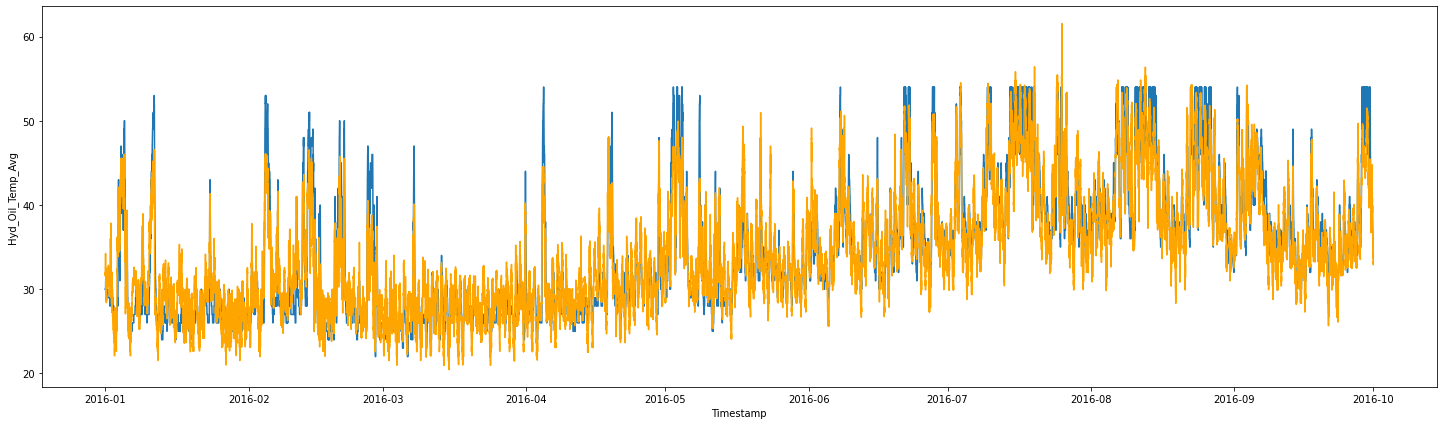

In [17]:
plt.figure(figsize=(25,7))
sns.lineplot(x=Y_train_1.index, y=Y_train_1['Hyd_Oil_Temp_Avg'])
sns.lineplot(x=predictions_train_1.index, y=predictions_train_1['Hyd_Oil_Temp_Avg'], color='orange')

In [ ]:
Y_test_1['Anomaly'] = errors_test_1['Hyd_Oil_Temp_Avg'] > (errors_train_1['Hyd_Oil_Temp_Avg'].mean() + 3 * errors_train_1['Hyd_Oil_Temp_Avg'].std())

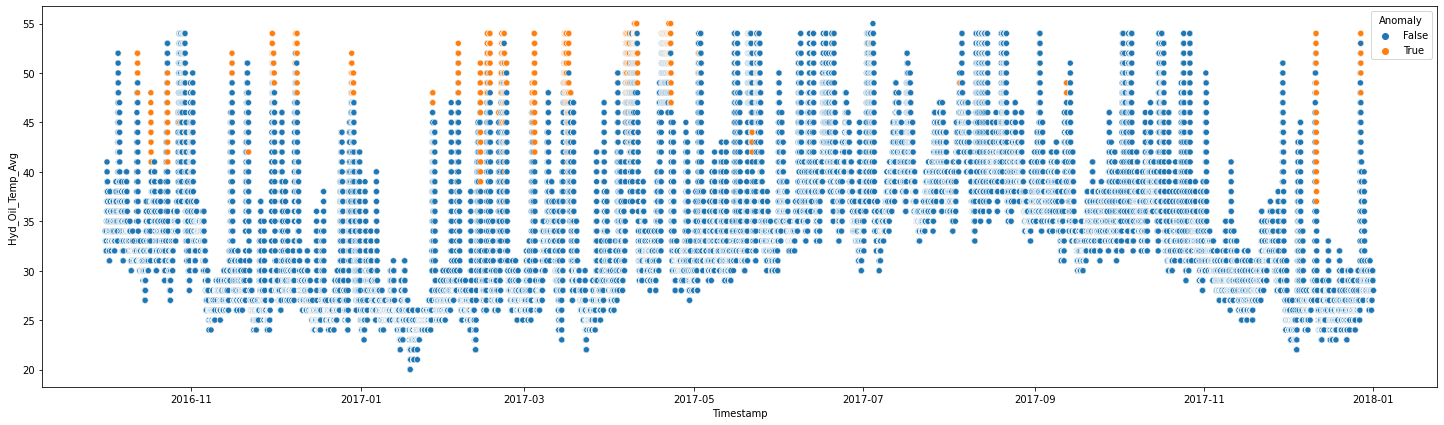

In [ ]:
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_1.reset_index())

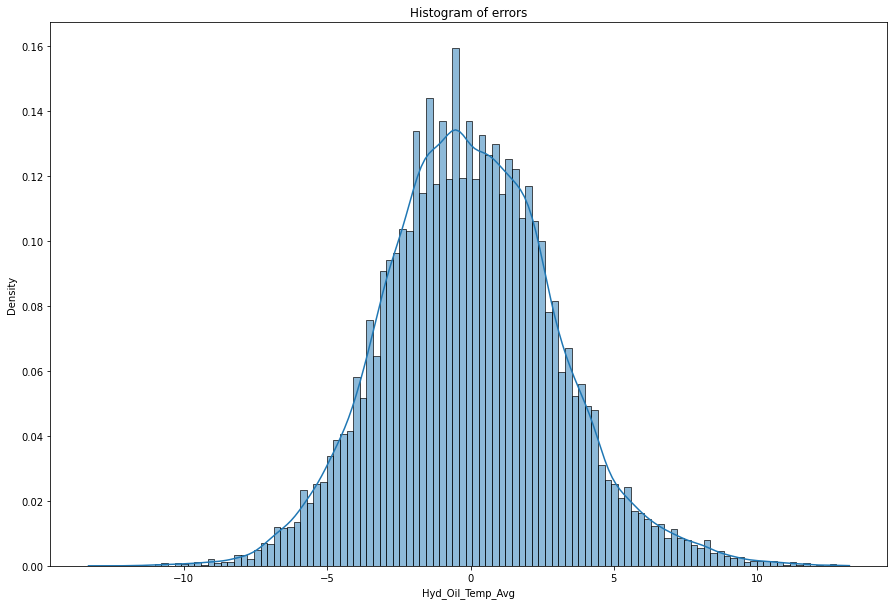

In [ ]:
#Distribution of errors
fig = plt.figure(figsize=(15,10))
errors_train_1['dataset'] = 'Train'
errors_test_1['dataset'] = 'Test'
ax=sns.histplot(pd.concat([errors_train_1, errors_test_1], ignore_index=True), x='Hyd_Oil_Temp_Avg', hue='dataset', kde=True, stat='density', common_norm=False)
ax.set_title('Histogram of errors');

Text(0, 0.5, 'Hyd Oil Temp Error [0C]')

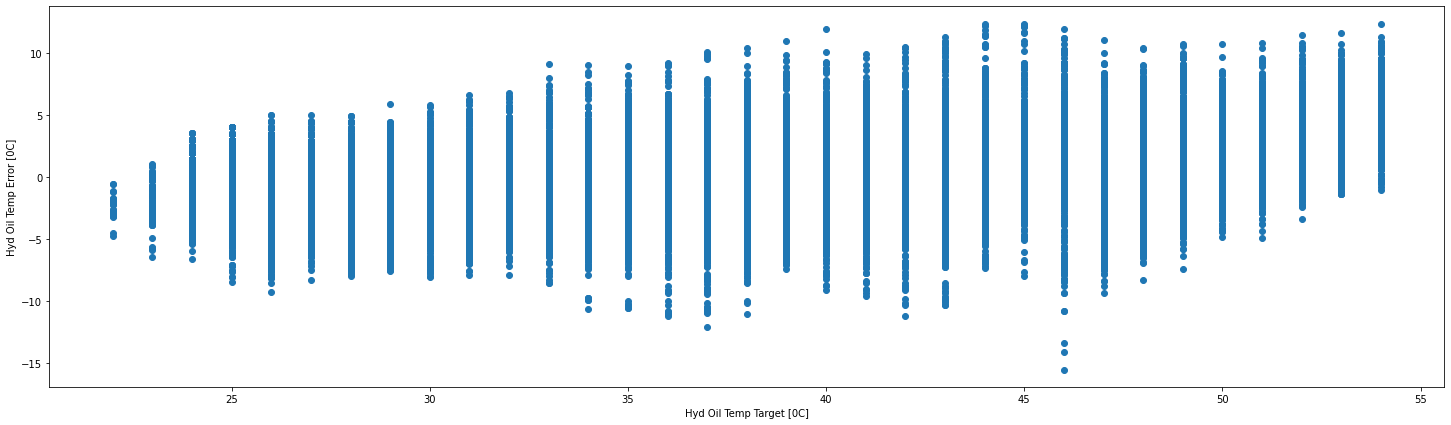

In [ ]:
#Error vs target
fig = plt.figure(figsize=(25,7))
plt.scatter(Y_train_1['Hyd_Oil_Temp_Avg'], errors_train_1['Hyd_Oil_Temp_Avg'])
plt.xlabel('Hyd Oil Temp Target [0C]')
plt.ylabel('Hyd Oil Temp Error [0C]')

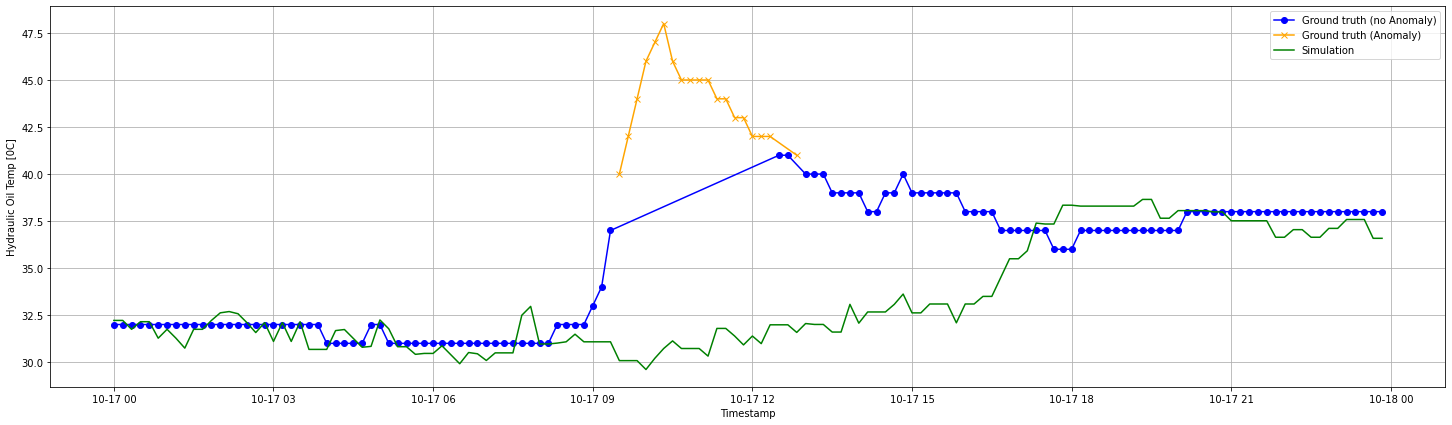

In [ ]:
#Failure 1: October 17, 2016 5:44 PM Hydraulic group error in the brake circuit
X_fail_1 = X_test_1.loc['2016-10-17':'2016-10-17']
Y_fail_1 = Y_test_1.loc['2016-10-17':'2016-10-17']
plot_predicted_vs_true(pd.DataFrame(model_1.predict(X_fail_1), columns=[y_column], index=X_fail_1.index),Y_fail_1, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_1.predict(X_fail_1), columns=[y_column], index=X_fail_1.index),Y_fail_1, y_column)

In [ ]:
#Logs around failure 1
log_data[log_data.Remark.str.contains('brake')]['2016-10-01':'2016-10-17']

,TimeReset,UnitTitle,Remark,UnitTitleDestination
TimeDetected,,,,
2016-10-17 17:19:00+00:00,2016-10-18 13:25:02,T11,High temperature brake disc,NaN
2016-10-17 17:33:29+00:00,2016-10-18 13:25:02,T11,High temperature brake disc,NaN


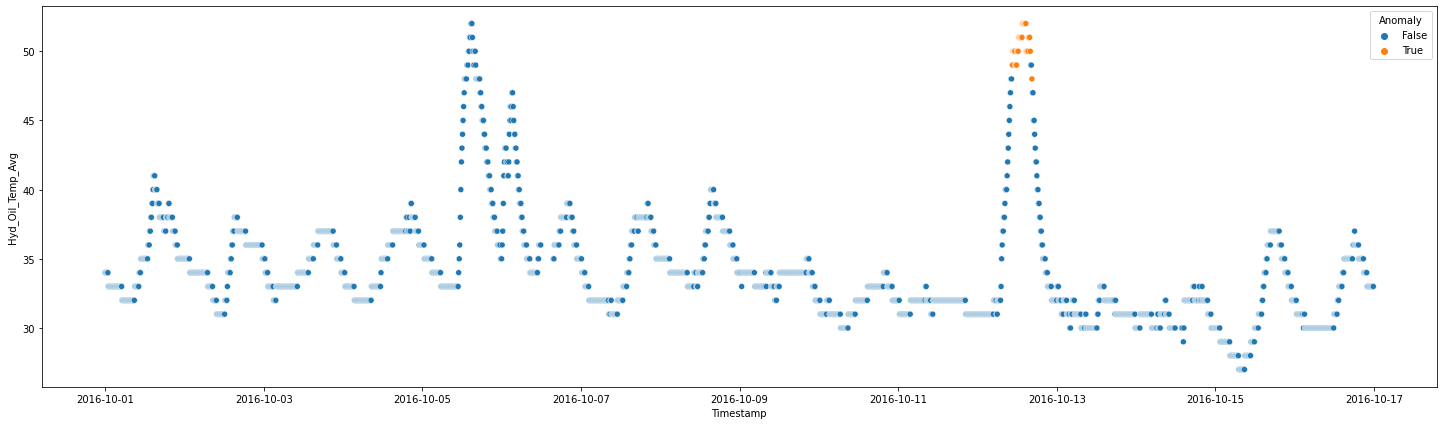

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_1['2016-10-01':'2016-10-16'].reset_index())

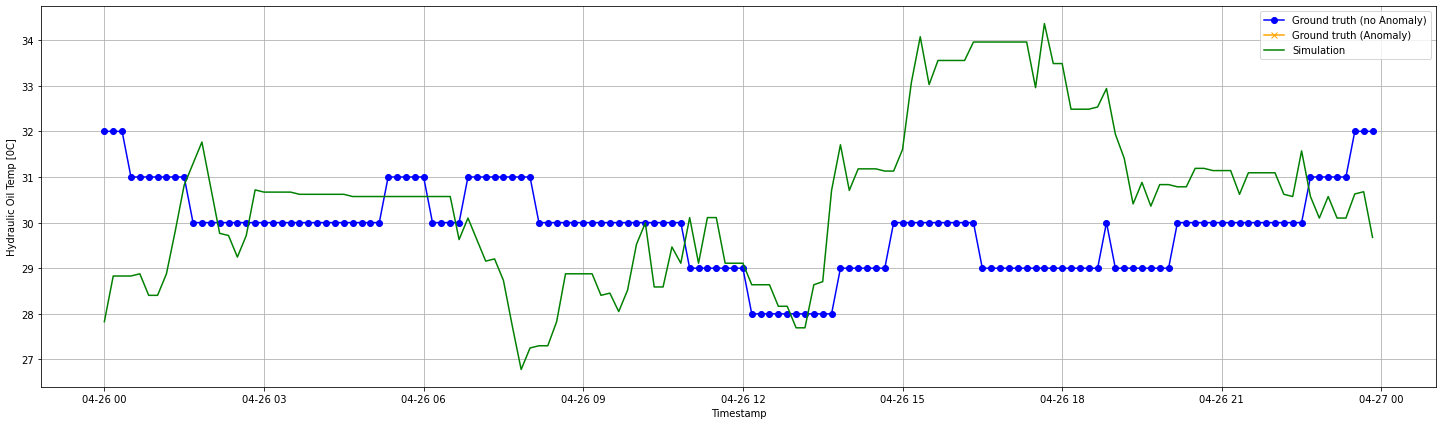

In [ ]:
#Failure 2: April 26, 2017 6:06 PM Hydraulic group error in the brake circuit
X_fail_2 = X_test_1.loc['2017-04-26':'2017-04-26']
Y_fail_2 = Y_test_1.loc['2017-04-26':'2017-04-26']
plot_predicted_vs_true(pd.DataFrame(model_1.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_1.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column)

In [ ]:
#Logs around failure 2
log_data[log_data.Remark.str.contains('brake')]['2017-04-01':'2017-04-26']

,TimeReset,UnitTitle,Remark,UnitTitleDestination
TimeDetected,,,,
2017-04-26 15:00:46+00:00,2017-04-26 18:51:51,T11,High temperature brake disc,NaN


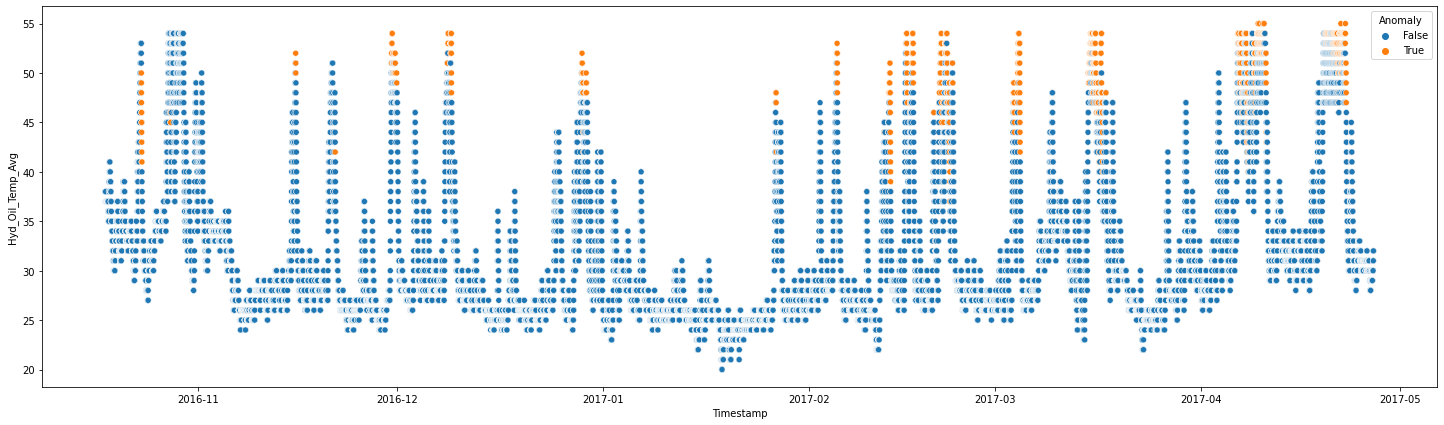

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_1['2016-10-18':'2017-04-26'].reset_index())

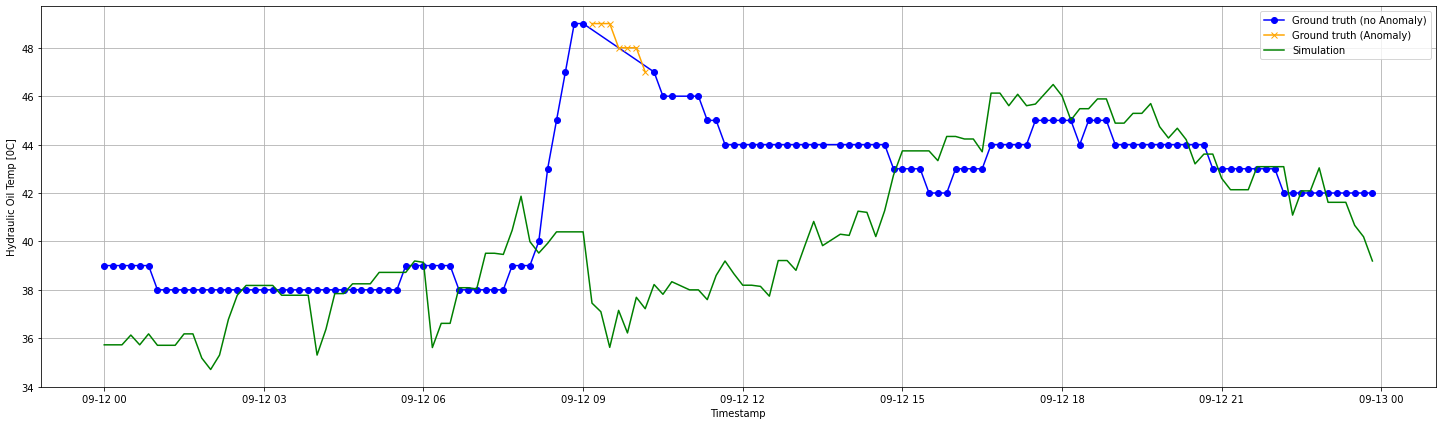

In [ ]:
#Failure 3: September 12, 2017 3:30 PM Hydraulic group error in the brake circuit
X_fail_3 = X_test_1.loc['2017-09-12':'2017-09-12']
Y_fail_3 = Y_test_1.loc['2017-09-12':'2017-09-12']
plot_predicted_vs_true(pd.DataFrame(model_1.predict(X_fail_3), columns=[y_column], index=X_fail_3.index),Y_fail_3, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_1.predict(X_fail_3), columns=[y_column], index=X_fail_3.index),Y_fail_3, y_column)

In [ ]:
#Logs around failure 3
log_data[log_data.Remark.str.contains('brake')]['2017-09-01':'2017-09-12']

,TimeReset,UnitTitle,Remark,UnitTitleDestination
TimeDetected,,,,
2017-09-12 14:40:15+00:00,2017-09-12 15:55:00,T11,High temperature brake disc,NaN


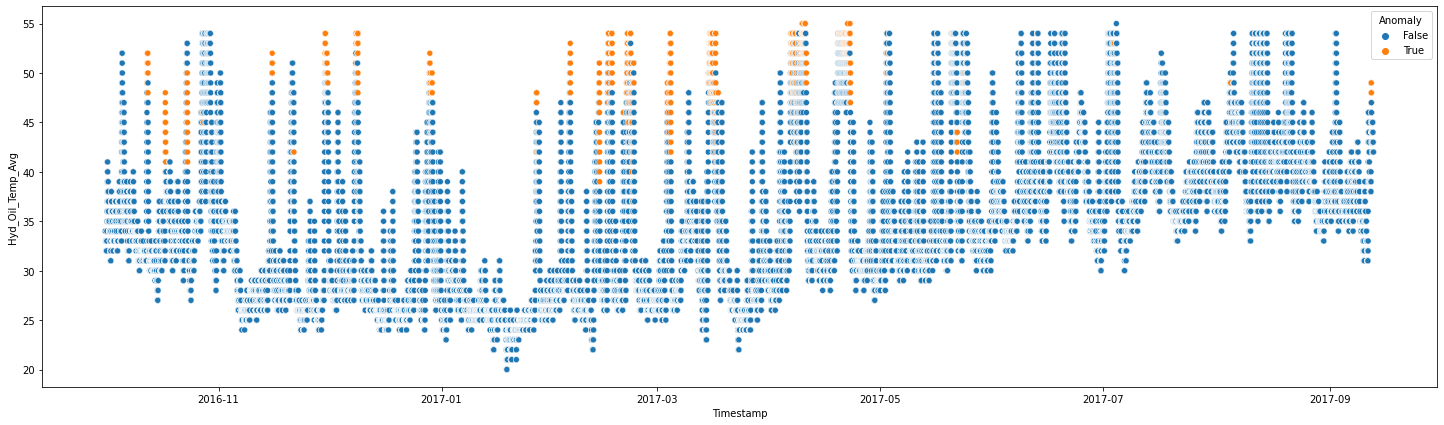

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_1['2016-04-27':'2017-09-12'].reset_index())

**Compare error distributions of all turbines**

In [ ]:
combined_errors_train = errors_train_1
combined_errors_train['turbine_id'] = 'T11'

combined_errors_test = errors_test_1
combined_errors_test['turbine_id'] = 'T11'

In [ ]:
for t_id in ['T01', 'T06', 'T07', 'T09']:
  _, _, _, _, errors_train, _, _, _, errors_test, _ = \
                        implement_pipeline_reg(all_data, train_date_start = '2016-01-01', train_date_end = '2016-09-30',
                                           test_date_start = '2016-10-01', test_date_end = '2018-01-01', y_column = y_column, turbine_id=t_id,
                         features=features);
  errors_train['turbine_id'] = t_id
  combined_errors_train = pd.concat([combined_errors_train, errors_train], ignore_index=True)

  errors_test['turbine_id'] = t_id
  combined_errors_test = pd.concat([combined_errors_test, errors_test], ignore_index=True)

Training model...
Evaluating model...
Score for training data:  0.8229313952318629
Score for test data:  0.8044010954018416
Training model...
Evaluating model...
Score for training data:  0.7002109448519451
Score for test data:  0.6694257869995115
Training model...
Evaluating model...
Score for training data:  0.5313893443809952
Score for test data:  0.5084627929549312
Training model...
Evaluating model...
Score for training data:  0.3044238783479388
Score for test data:  0.06297104678898546


In [ ]:
combined_errors_train.columns

Index(['Hyd_Oil_Temp_Avg', 'turbine_id'], dtype='object')

In [ ]:
T7 = combined_errors_train[combined_errors_train.turbine_id == 'T07'].reset_index()
T7.loc[0 : T7.shape[0] // 2, 'h']

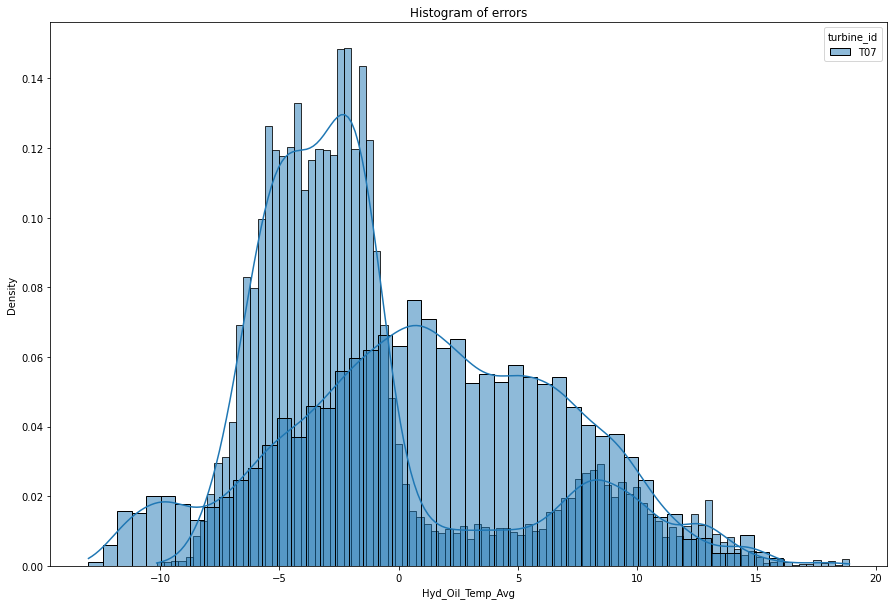

In [ ]:
fig = plt.figure(figsize=(15,10))
ax=sns.histplot(data=T7[0 : T7.shape[0] // 2], x='Hyd_Oil_Temp_Avg', hue='turbine_id', kde=True, stat='density')
ax=sns.histplot(data=T7[T7.shape[0] // 2 : ], x='Hyd_Oil_Temp_Avg', hue='turbine_id', kde=True, stat='density')
ax.set_title('Histogram of errors');

**Deep Learning**

In [ ]:
y_column = 'Hyd_Oil_Temp_Avg'

**Batch 1:** Train between Jan and September, Test between October 2016 and December 2017

In [ ]:
features = ['Nac_Temp_Avg', 'Gen_SlipRing_Temp_Avg', 'Cont_Top_Temp_Avg', 'Amb_Temp_Avg', 'Hyd_Oil_Temp_Avg']

dataset_2, X_train_2, Y_train_2, predictions_train_2, errors_train_2, X_test_2, Y_test_2, predictions_test_2, errors_test_2, model_2, scaler_input, scaler_target = \
                        implement_pipeline_mlp(all_data, train_date_start = '2016-01-01', train_date_end = '2016-09-30',
                                           test_date_start = '2016-10-01', test_date_end = '2018-01-01', y_column = y_column, turbine_id='T11',
                         features=features, epochs=200, normalize=True);

Training model...
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 16)                80        
                                                                 
 dropout_19 (Dropout)        (None, 16)                0         
                                                                 
 dense_29 (Dense)            (None, 8)                 136       
                                                                 
 dropout_20 (Dropout)        (None, 8)                 0         
                                                                 
 dense_30 (Dense)            (None, 1)                 9         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
393/393 - 2s - loss: 0.058

In [ ]:
Y_test_2['Anomaly'] = errors_test_2['Hyd_Oil_Temp_Avg'] > (errors_train_2['Hyd_Oil_Temp_Avg'].mean() + 3 * errors_train_2['Hyd_Oil_Temp_Avg'].std())

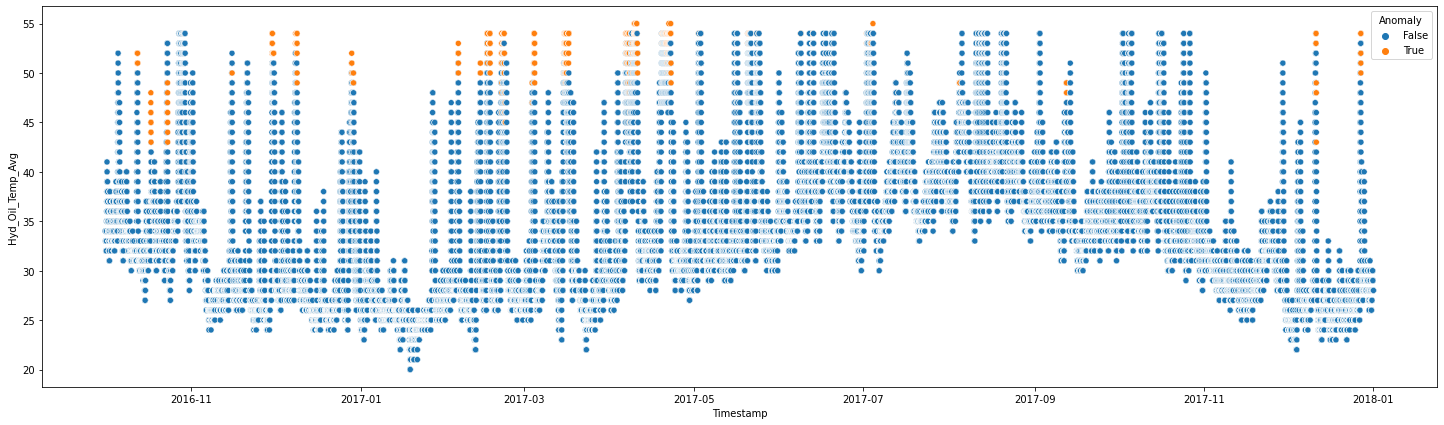

In [ ]:
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_2.reset_index())

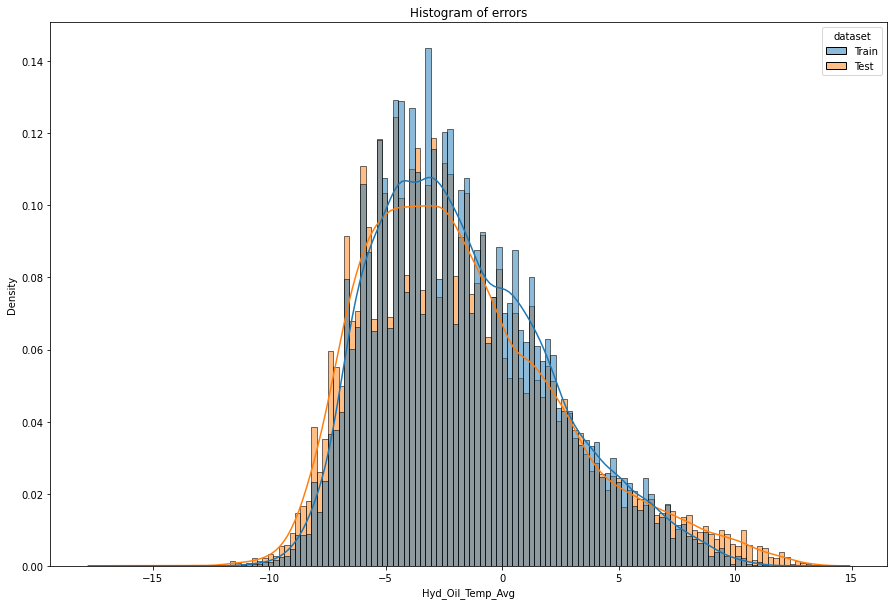

In [ ]:
#Distribution of errors
fig = plt.figure(figsize=(15,10))
errors_train_2['dataset'] = 'Train'
errors_test_2['dataset'] = 'Test'
ax=sns.histplot(pd.concat([errors_train_2, errors_test_2], ignore_index=True), x='Hyd_Oil_Temp_Avg', hue='dataset', kde=True, stat='density', common_norm=False)
ax.set_title('Histogram of errors');

Text(0, 0.5, 'Hyd Oil Temp Error [0C]')

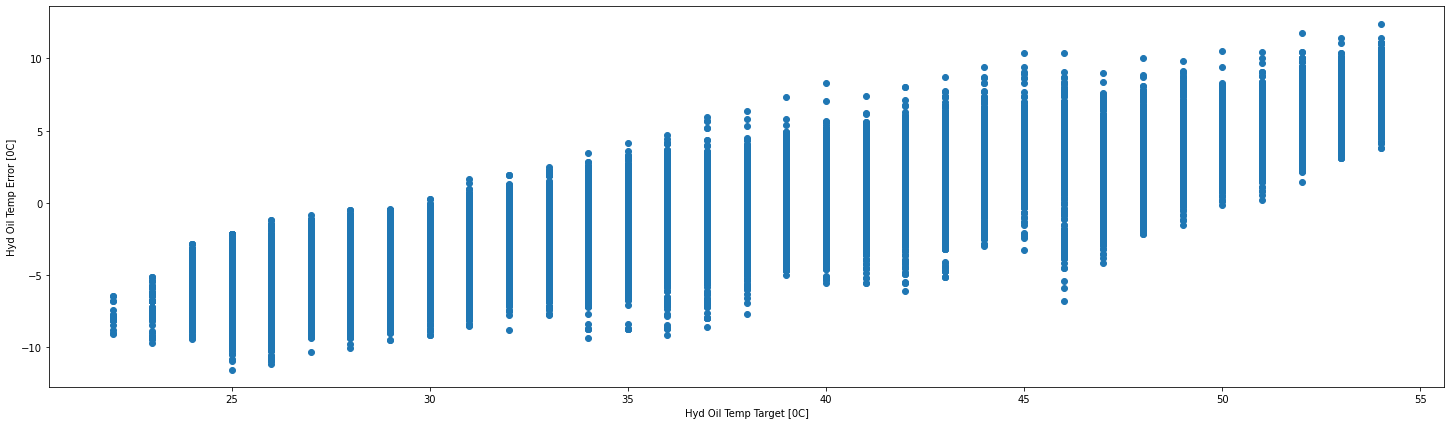

In [ ]:
#Error vs target
fig = plt.figure(figsize=(25,7))
plt.scatter(Y_train_2['Hyd_Oil_Temp_Avg'], errors_train_2['Hyd_Oil_Temp_Avg'])
plt.xlabel('Hyd Oil Temp Target [0C]')
plt.ylabel('Hyd Oil Temp Error [0C]')

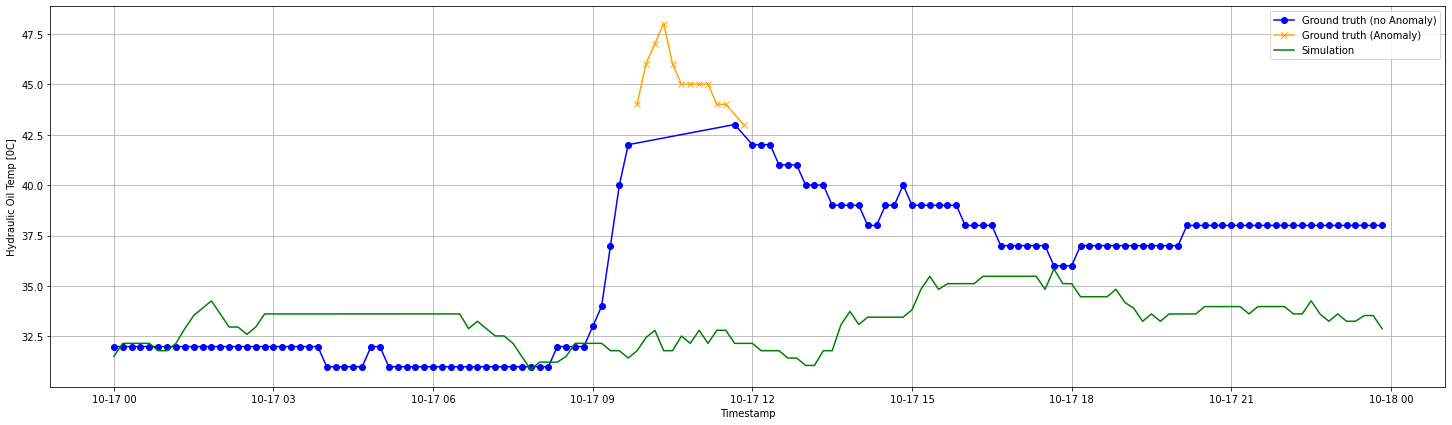

In [ ]:
#Failure 1: October 17, 2016 5:44 PM Hydraulic group error in the brake circuit
X_fail_1 = X_test_2.loc['2016-10-17':'2016-10-17']
Y_fail_1 = Y_test_2.loc['2016-10-17':'2016-10-17']

x_fail_1 = scaler_input.transform(X_fail_1)

plot_predicted_vs_true(pd.DataFrame(scaler_target.inverse_transform(model_2.predict(x_fail_1)), columns=[y_column], index=X_fail_1.index),Y_fail_1, y_column, hue='Anomaly')
#plot_predicted_vs_true(pd.DataFrame(model_2.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_2.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column)

In [ ]:
#Logs around failure 1
log_data[log_data.Remark.str.contains('brake')]['2016-10-01':'2016-10-17']

,TimeReset,UnitTitle,Remark,UnitTitleDestination
TimeDetected,,,,
2016-10-17 17:19:00+00:00,2016-10-18 13:25:02,T11,High temperature brake disc,NaN
2016-10-17 17:33:29+00:00,2016-10-18 13:25:02,T11,High temperature brake disc,NaN


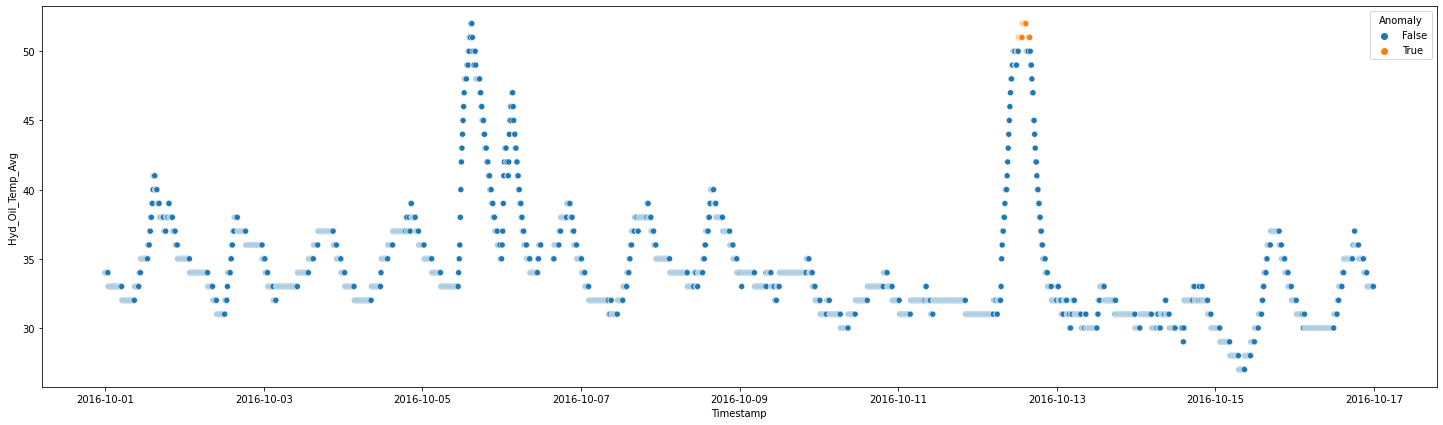

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_2['2016-10-01':'2016-10-16'].reset_index())

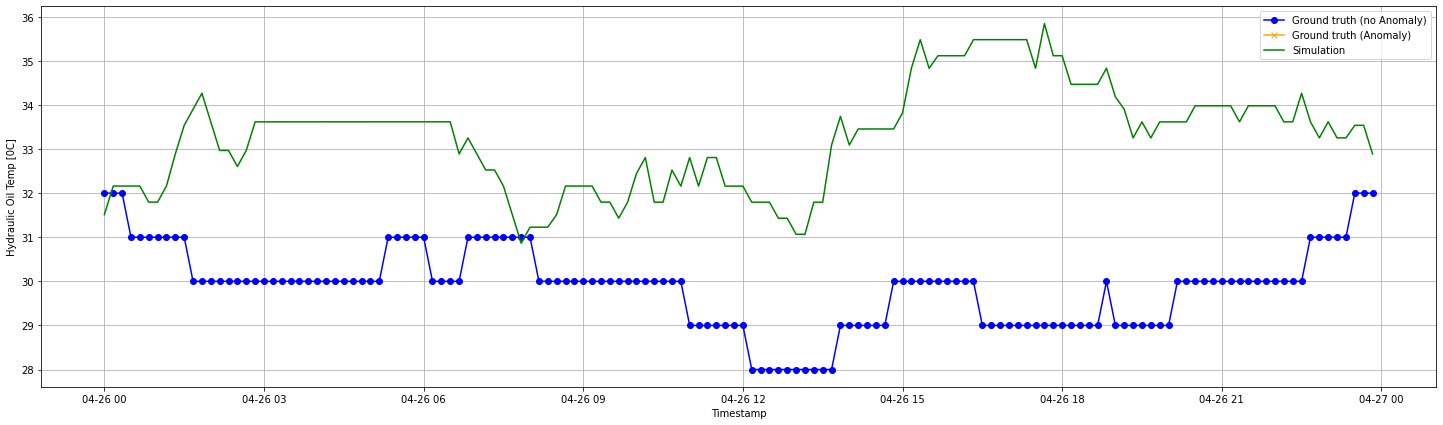

In [ ]:
#Failure 2: April 26, 2017 6:06 PM Hydraulic group error in the brake circuit
X_fail_2 = X_test_2.loc['2017-04-26':'2017-04-26']
Y_fail_2 = Y_test_2.loc['2017-04-26':'2017-04-26']

x_fail_2 = scaler_input.transform(X_fail_2)

plot_predicted_vs_true(pd.DataFrame(scaler_target.inverse_transform(model_2.predict(x_fail_2)), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column, hue='Anomaly')
#plot_predicted_vs_true(pd.DataFrame(model_2.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_2.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column)

In [ ]:
#Logs around failure 2
log_data[log_data.Remark.str.contains('brake')]['2017-04-01':'2017-04-26']

,TimeReset,UnitTitle,Remark,UnitTitleDestination
TimeDetected,,,,
2017-04-26 15:00:46+00:00,2017-04-26 18:51:51,T11,High temperature brake disc,NaN


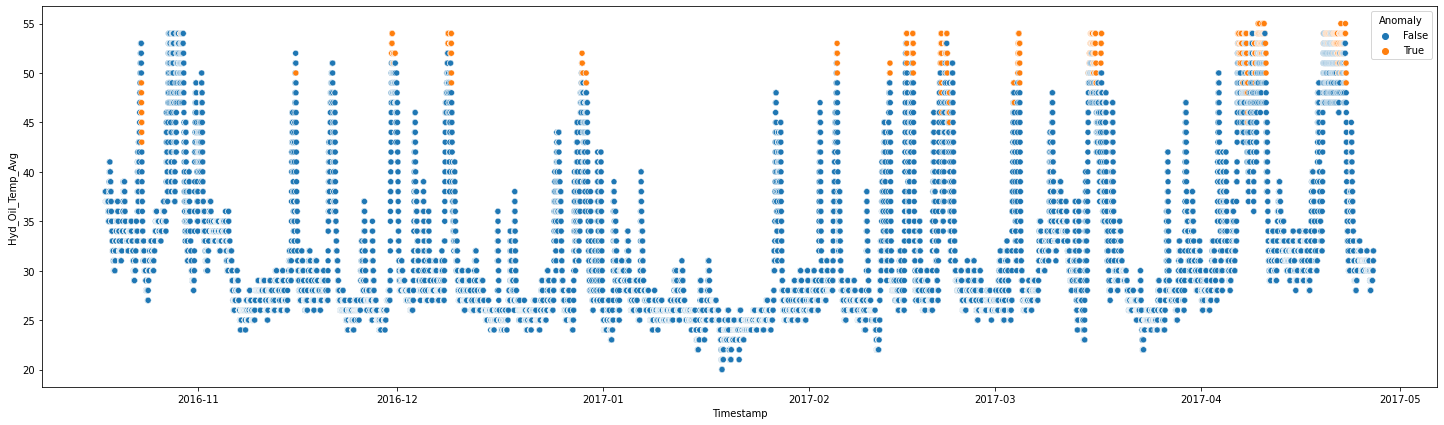

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_2['2016-10-18':'2017-04-26'].reset_index())

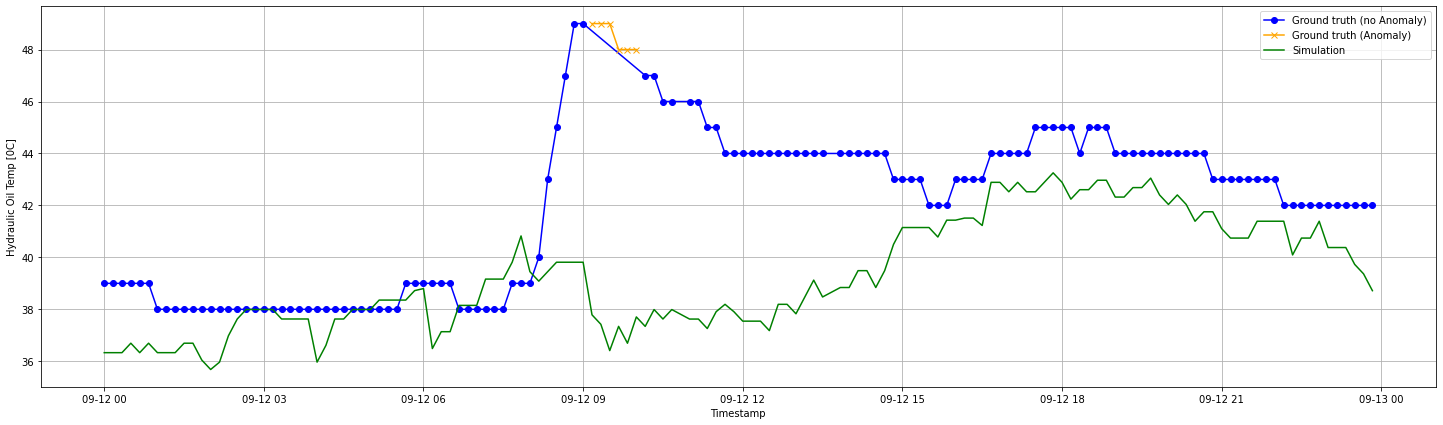

In [ ]:
#Failure 3: September 12, 2017 3:30 PM Hydraulic group error in the brake circuit
X_fail_3 = X_test_2.loc['2017-09-12':'2017-09-12']
Y_fail_3 = Y_test_2.loc['2017-09-12':'2017-09-12']

x_fail_3 = scaler_input.transform(X_fail_3)

plot_predicted_vs_true(pd.DataFrame(scaler_target.inverse_transform(model_2.predict(x_fail_3)), columns=[y_column], index=X_fail_3.index),Y_fail_3, y_column, hue='Anomaly')
#plot_predicted_vs_true(pd.DataFrame(model_2.predict(X_fail_3), columns=[y_column], index=X_fail_3.index),Y_fail_3, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_2.predict(X_fail_3), columns=[y_column], index=X_fail_3.index),Y_fail_3, y_column)

In [ ]:
#Logs around failure 3
log_data[log_data.Remark.str.contains('brake')]['2017-09-01':'2017-09-12']

,TimeReset,UnitTitle,Remark,UnitTitleDestination
TimeDetected,,,,
2017-09-12 14:40:15+00:00,2017-09-12 15:55:00,T11,High temperature brake disc,NaN


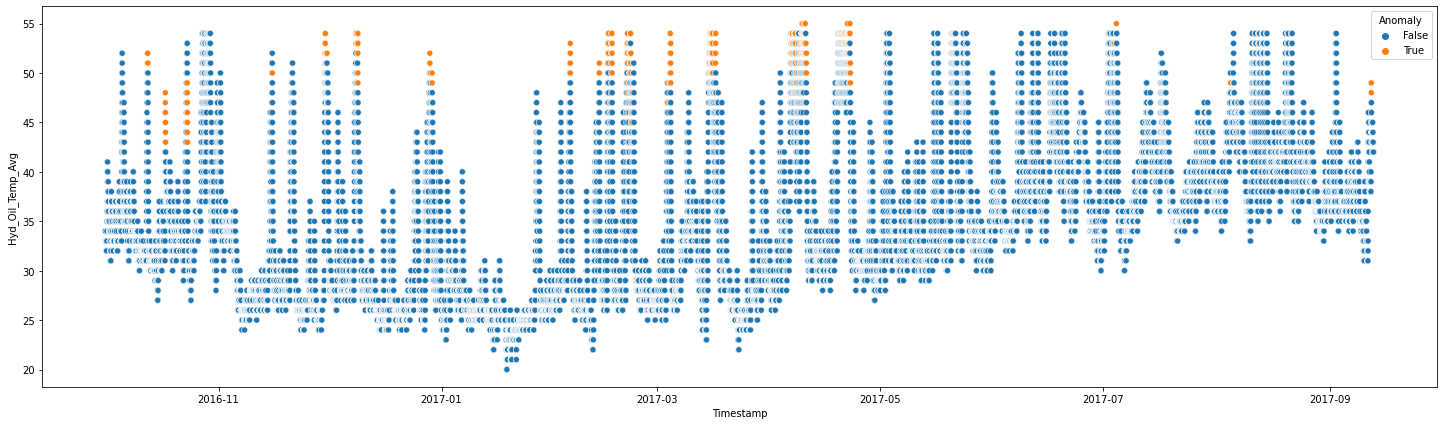

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_2['2016-04-27':'2017-09-12'].reset_index())

**Compare error distributions of all turbines**

In [ ]:
combined_errors_train_2 = errors_train_2
combined_errors_train_2['turbine_id'] = 'T11'

combined_errors_test_2 = errors_test_2
combined_errors_test_2['turbine_id'] = 'T11'

In [ ]:
for t_id in ['T01', 'T06', 'T07', 'T09']:
  _, _, _, _, errors_train, _, _, _, errors_test, _, _, _ = \
                         implement_pipeline_mlp(all_data, train_date_start = '2016-01-01', train_date_end = '2016-09-30',
                                           test_date_start = '2016-10-01', test_date_end = '2018-01-01', y_column = y_column, turbine_id=t_id,
                         features=features, epochs=200, normalize=True)
  errors_train['turbine_id'] = t_id
  combined_errors_train_2 = pd.concat([combined_errors_train_2, errors_train], ignore_index=True)

  errors_test['turbine_id'] = t_id
  combined_errors_test_2 = pd.concat([combined_errors_test_2, errors_test], ignore_index=True)

Training model...
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 16)                80        
                                                                 
 dropout_25 (Dropout)        (None, 16)                0         
                                                                 
 dense_38 (Dense)            (None, 8)                 136       
                                                                 
 dropout_26 (Dropout)        (None, 8)                 0         
                                                                 
 dense_39 (Dense)            (None, 1)                 9         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
393/393 - 2s - loss: 0.04

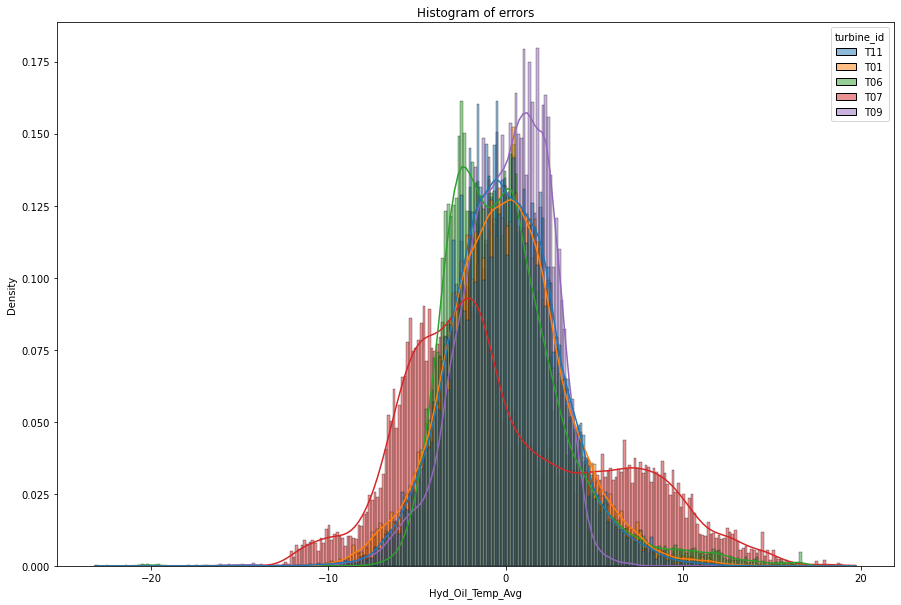

In [ ]:
fig = plt.figure(figsize=(15,10))
ax=sns.histplot(data=combined_errors_train_2, x='Hyd_Oil_Temp_Avg', hue='turbine_id', kde=True, stat='density', common_norm=False)
ax.set_title('Histogram of errors');